## Data Loading

In [1]:
import pandas as pd
import numpy as np

splits = {
    'train': 'train.csv',
    'validation': 'valid.csv',
    'test': 'test.csv'
}

def load_liar2_data():
    """Load the LIAR-2 train/val/test splits into dataframes."""
    train_df = pd.read_csv("hf://datasets/chengxuphd/liar2/" + splits["train"])
    val_df   = pd.read_csv("hf://datasets/chengxuphd/liar2/" + splits["validation"])
    test_df  = pd.read_csv("hf://datasets/chengxuphd/liar2/" + splits["test"])
    return train_df, val_df, test_df

train_df, val_df, test_df = load_liar2_data()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))
print("\nColumns:", train_df.columns.tolist())

target_names = ["Pants on fire","False","Barely-true","Half-true","Mostly-true","True"]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: 18369
Validation size: 2297
Test size: 2296

Columns: ['id', 'label', 'statement', 'date', 'subject', 'speaker', 'speaker_description', 'state_info', 'true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'context', 'justification']


## Preprocessing

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

MAX_FEATURES = 5000

def prepare_text_fields(df):
    """
    Concatenate several text fields into a single string for the 'body'.
    Minimal cleaning is done here.
    """
    df = df.fillna("")  # Just in case of missing values
    # For 'headline' we will use the 'statement' as-is.
    headline_texts = df["statement"].astype(str).tolist()
    
    # For 'body' we can combine subject, speaker, justification, etc.
    # Adjust this as you like:
    body_texts = (
        df["subject"].astype(str) + " " + 
        df["speaker"].astype(str) + " " +
        df["justification"].astype(str)
    ).tolist()
    
    return headline_texts, body_texts

# Prepare train, val, test text
train_headlines, train_bodies = prepare_text_fields(train_df)
val_headlines,   val_bodies   = prepare_text_fields(val_df)
test_headlines,  test_bodies  = prepare_text_fields(test_df)

# ----- Step 1: Fit a CountVectorizer for TF on the training set -----
count_vect_headline = CountVectorizer(
    max_features=MAX_FEATURES, stop_words='english'
)
count_vect_body = CountVectorizer(
    max_features=MAX_FEATURES, stop_words='english'
)

# Learn vocab and transform to TF counts
train_tf_headline = count_vect_headline.fit_transform(train_headlines)
train_tf_body     = count_vect_body.fit_transform(train_bodies)

# Validation / test transformation (using training vocab)
val_tf_headline   = count_vect_headline.transform(val_headlines)
val_tf_body       = count_vect_body.transform(val_bodies)
test_tf_headline  = count_vect_headline.transform(test_headlines)
test_tf_body      = count_vect_body.transform(test_bodies)

# ----- Step 2: Fit a TfidfVectorizer to compute TF-IDF for the cos sim -----
tfidf_vect_headline = TfidfVectorizer(
    max_features=MAX_FEATURES, stop_words='english', norm='l2'
)
tfidf_vect_body = TfidfVectorizer(
    max_features=MAX_FEATURES, stop_words='english', norm='l2'
)

train_tfidf_headline = tfidf_vect_headline.fit_transform(train_headlines)
train_tfidf_body     = tfidf_vect_body.fit_transform(train_bodies)

val_tfidf_headline   = tfidf_vect_headline.transform(val_headlines)
val_tfidf_body       = tfidf_vect_body.transform(val_bodies)

test_tfidf_headline  = tfidf_vect_headline.transform(test_headlines)
test_tfidf_body      = tfidf_vect_body.transform(test_bodies)

# ----- Step 3: Compute Cosine Similarities -----
# We'll compute the similarity row-by-row (headline vs body).
# Careful: each row is a sparse vector. We'll convert each row to 1D dense for the similarity.

def row_cosine_sim(tfidfA, tfidfB):
    # tfidfA, tfidfB are each (N, dim)
    # We'll return an array of shape (N, 1) with cos sims.
    sims = []
    for i in range(tfidfA.shape[0]):
        # Extract row i as dense
        A = tfidfA[i].toarray()
        B = tfidfB[i].toarray()
        # Cosine similarity for this row
        sim = cosine_similarity(A, B)[0,0]
        sims.append(sim)
    return np.array(sims).reshape(-1, 1)

train_cos_sim = row_cosine_sim(train_tfidf_headline, train_tfidf_body)
val_cos_sim   = row_cosine_sim(val_tfidf_headline,   val_tfidf_body)
test_cos_sim  = row_cosine_sim(test_tfidf_headline,  test_tfidf_body)

# ----- Step 4: Final Feature Vectors = [TF_headline, TF_body, cos_sim] -----
import scipy.sparse as sp

train_X = sp.hstack([train_tf_headline, train_tf_body, train_cos_sim])
val_X   = sp.hstack([val_tf_headline,   val_tf_body,   val_cos_sim])
test_X  = sp.hstack([test_tf_headline,  test_tf_body,  test_cos_sim])

# Encode labels numerically
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_df["label"].tolist())
val_y   = label_encoder.transform(val_df["label"].tolist())
test_y  = label_encoder.transform(test_df["label"].tolist())

print("Feature shape (train):", train_X.shape)
print("Feature shape (val):", val_X.shape)
print("Feature shape (test):", test_X.shape)
print("Labels:", list(label_encoder.classes_))


Feature shape (train): (18369, 10001)
Feature shape (val): (2297, 10001)
Feature shape (test): (2296, 10001)
Labels: [0, 1, 2, 3, 4, 5]


## Single-Layer MLP Classifier

In [3]:
import tensorflow as tf
from tensorflow import keras

# Hyperparameters from the paper (roughly)
hidden_size = 100
dropout_rate = 0.6
l2_alpha = 1e-4
learning_rate = 1e-2
batch_size = 500
epochs = 20

num_features = train_X.shape[1]
num_classes = len(label_encoder.classes_)

# Build the model
model = keras.Sequential([
    # Input layer
    keras.layers.InputLayer(input_shape=(num_features,)),
    
    # Hidden layer
    keras.layers.Dense(
        hidden_size, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_alpha)
    ),
    keras.layers.Dropout(dropout_rate),
    
    # Output layer
    keras.layers.Dense(
        num_classes, 
        activation='softmax',
        kernel_regularizer=keras.regularizers.l2(l2_alpha)
    )
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Convert sparse matrices to CSR float32 for efficient conversion
train_X_csr = train_X.astype('float32').tocsr()
val_X_csr   = val_X.astype('float32').tocsr()
test_X_csr  = test_X.astype('float32').tocsr()

# We’ll convert them to dense on the fly in a generator (not memory-friendly for large data),
# or, for small enough data, just do toarray(). For large data, you might use a tf.data pipeline.
# For demonstration, we’ll do .toarray() here (assuming dataset is not huge).
train_X_array = train_X_csr.toarray()
val_X_array   = val_X_csr.toarray()
test_X_array  = test_X_csr.toarray()

history = model.fit(
    train_X_array, train_y,
    validation_data=(val_X_array, val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_X_array, test_y, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


2025-01-03 21:30:15.020665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3855 - loss: 1.5667 - val_accuracy: 0.5276 - val_loss: 1.4212
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6165 - loss: 1.2437 - val_accuracy: 0.5333 - val_loss: 1.5040
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6985 - loss: 1.1385 - val_accuracy: 0.5224 - val_loss: 1.6254
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7348 - loss: 1.1113 - val_accuracy: 0.5259 - val_loss: 1.7245
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7663 - loss: 1.0965 - val_accuracy: 0.5329 - val_loss: 1.7797
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7754 - loss: 1.1043 - val_accuracy: 0.5268 - val_loss: 1.8582
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7872 - loss: 1.1200 - val_accuracy: 0.5324 - val_loss: 1.9441
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7900 - loss: 1.1406 - val_accuracy: 0.5255 - v

In [4]:
import numpy as np

test_probs = model.predict(test_X_array)  # shape [n_samples, num_classes]
test_preds = np.argmax(test_probs, axis=1)  # integer labels


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


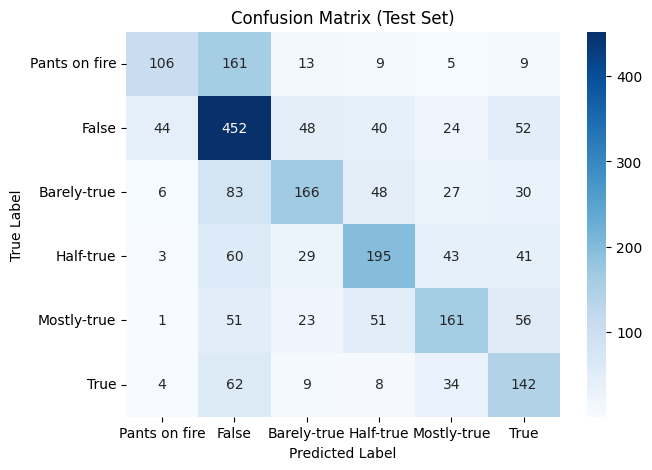

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, test_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=target_names, 
            yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [6]:
from sklearn.metrics import accuracy_score
print("Test Accuracy (sklearn):", accuracy_score(test_y, test_preds))


Test Accuracy (Keras evaluate): 0.5322
Test Accuracy (sklearn): 0.5322299651567944


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr_model = LogisticRegression(max_iter=1000)  # or tune as you wish
lr_model.fit(train_X, train_y)  # can fit directly on the sparse matrix
lr_preds = lr_model.predict(test_X)

print(classification_report(test_y, lr_preds, target_names=target_names))

# For top features (e.g., for label i) 
# The shape of lr_model.coef_ is [num_classes, num_features]
coef_array = lr_model.coef_
for idx, label_name in enumerate(target_names):
    top10_idx = np.argsort(coef_array[idx])[-10:]      # largest positive 10
    top10_feats = [str(i) for i in top10_idx]
    print(f"Top 10 features for label {label_name}: {top10_feats}")


               precision    recall  f1-score   support

Pants on fire       0.46      0.46      0.46       303
        False       0.52      0.56      0.54       660
  Barely-true       0.53      0.49      0.51       360
    Half-true       0.51      0.50      0.50       371
  Mostly-true       0.50      0.48      0.49       343
         True       0.42      0.43      0.43       259

     accuracy                           0.50      2296
    macro avg       0.49      0.49      0.49      2296
 weighted avg       0.50      0.50      0.50      2296

Top 10 features for label Pants on fire: ['6788', '4949', '7523', '6886', '7835', '9934', '7785', '8186', '6777', '6281']
Top 10 features for label False: ['5105', '6211', '9119', '2282', '9289', '4362', '6535', '617', '2625', '7964']
Top 10 features for label Barely-true: ['6681', '9266', '6887', '8743', '6106', '7323', '6209', '7549', '7077', '6586']
Top 10 features for label Half-true: ['8162', '7316', '5701', '6109', '7648', '8232', '5392'